# Analyse patient data

**Objective: from clinical data of patient predict future myocardial infraction**

## 0. Init

In [1]:
# Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Constants
path_to_data = "patient_mi_data/full_mi_patient_data_no_na.csv"

## 1. Load data and select features

### 1.1 Load data

In [3]:
df = pd.read_csv(path_to_data)
df = df.set_index("sjid")

print("Nb of entries: {}".format(len(df)))
df.head()

Nb of entries: 984


,sex,age,bmi,diabetes_hist,smoking_bln,hypertension_hist,cholesterolemia_hist,prev_CVD,eGFR_bln,resuscitation,...,lvef_comb,grace_calc,death_mi,time_to_death_mi,mi,nb_mi,time_to_mi,revasc,nb_revasc,time_to_revasc
sjid,,,,,,,,,,,,,,,,,,,,,
003-529-877,0,59.000000,31.200001,0,0,1,1.0,0,72.170715,0.0,...,55.0,118.0,False,-1,False,0,-1.0,True,1,1207.0
003-551-891,1,87.000000,22.000000,0,2,0,0.0,0,85.532219,0.0,...,65.0,154.0,False,-1,False,0,-1.0,False,0,-1.0
003-648-529,0,51.599998,23.000000,0,0,0,1.0,1,80.782486,0.0,...,55.0,129.0,False,-1,False,0,-1.0,True,1,2080.0
005-251-825,0,60.200001,26.100000,0,2,0,1.0,0,105.978470,0.0,...,45.0,135.0,False,-1,False,0,-1.0,False,0,-1.0
005-561-090,1,80.000000,22.299999,0,1,1,1.0,0,52.820919,0.0,...,50.0,164.0,False,-1,False,0,-1.0,False,0,-1.0


### 1.2 Remove irrelevant classes

In [4]:
# Remove classes that won't be used now
df = df.drop(columns=['nb_mi', 'time_to_mi', 'death_mi', 'time_to_death_mi', 'revasc', 'nb_revasc', 'time_to_revasc'])

### 1.3 Analyse data

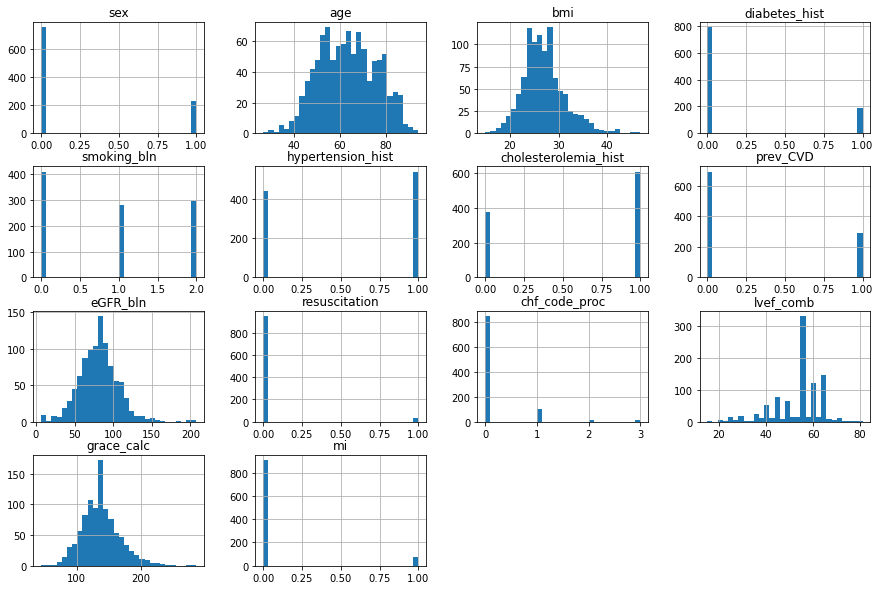

In [5]:
df_tmp = df.copy()
df_tmp["mi"] = df_tmp["mi"].astype(float)
df_tmp.hist(bins=30, figsize=(15, 10));

In [6]:
print("Nb of patient with MI is {} over {} patients".format(len(df[df["mi"]==1]), len(df)))
print("Percentage of patient without MI is {:.2f}%".format(100*len(df[df["mi"]==0])/len(df)))

Nb of patient with MI is 78 over 984 patients
Percentage of patient without MI is 92.07%


In [7]:
df.corr()['mi'][:].sort_values(ascending=False) # -1 column is mi

mi                      1.000000
prev_CVD                0.179125
diabetes_hist           0.130808
hypertension_hist       0.068340
age                     0.055307
cholesterolemia_hist    0.052682
bmi                     0.041740
grace_calc              0.017207
chf_code_proc           0.010277
smoking_bln            -0.003967
resuscitation          -0.012868
lvef_comb              -0.043889
sex                    -0.053522
eGFR_bln               -0.099712
Name: mi, dtype: float64

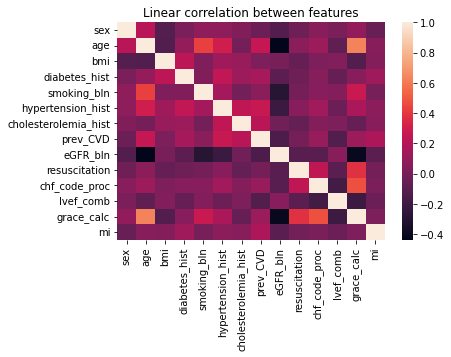

In [8]:
corr = df.corr()
sns.heatmap(corr);
plt.title("Linear correlation between features");

In [9]:
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.25:
            print(df.columns[i], " and ", df.columns[j], " : ", corr.iloc[i,j])

age  and  smoking_bln  :  0.4282399232457508
age  and  hypertension_hist  :  0.2999509985544882
age  and  prev_CVD  :  0.25526867074286974
age  and  eGFR_bln  :  -0.43771534310396076
age  and  grace_calc  :  0.6268759031261012
smoking_bln  and  eGFR_bln  :  -0.29024129534552146
smoking_bln  and  grace_calc  :  0.2700443607098035
hypertension_hist  and  prev_CVD  :  0.26634444256795586
eGFR_bln  and  grace_calc  :  -0.40887430556140736
resuscitation  and  grace_calc  :  0.37915584743323094
chf_code_proc  and  grace_calc  :  0.47340548530522386


### 1.4 Remoe unrelevant data

lvef has too much missing data. grace_calc has important number of missing data (10%), has correlation with other features and few correlation with MI

In [10]:
df = df.drop(columns=["grace_calc", "lvef_comb"])

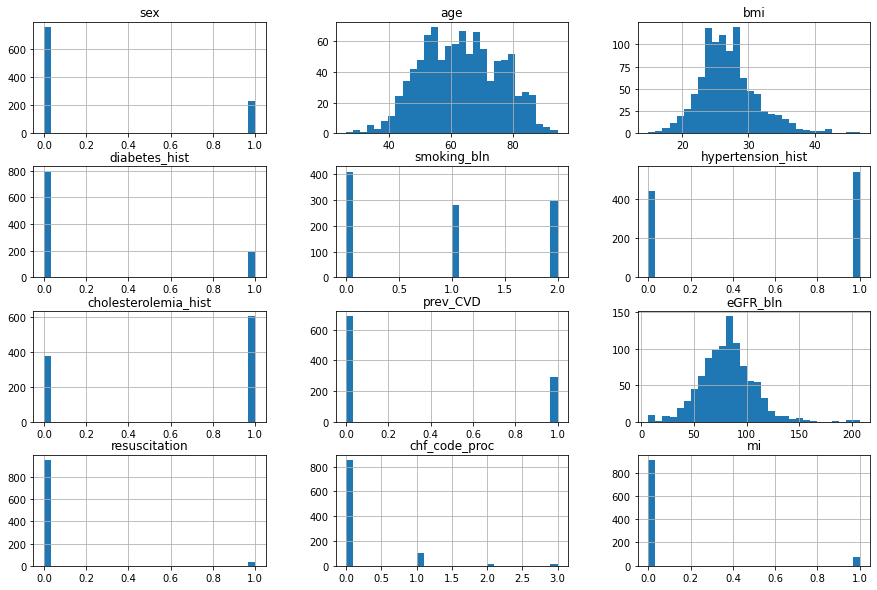

In [11]:
df_tmp = df.copy()
df_tmp["mi"] = df_tmp["mi"].astype(float)
df_tmp.hist(bins=30, figsize=(15, 10));

In [12]:
# Separate test df (avoid overfitting of HP)
df_train_valid, df_test = train_test_split(df, test_size=0.1)

## 2 Train/Test procedure

In [13]:
def train_test_skl(clf, X_train, y_train, X_test, y_test, extend, normalise, class_minus_one):
    """ 
    Aim: Train and test a sklearn classifier for different configurations
    
    Params:
        - clf: classifier
        - X_train, X_test: train and test features
        - y_train, y_test: train and test labels
        - extend: if the dataset has to be balanced or not (0:no, -1: undersampling, 1: oversampling)
        - normalise: if the features have to be normlaised (only the continuous one)
        - class_minus_one: convert 0/1 label to -1/1 label for SVM
        
    Output: F1 and accuracy on testing and training
    """
    
    if extend == 1:
        y_train_mi = y_train[y_train==1]
        y_train_no_mi = y_train[y_train==0]
        nb_mi_to_add = len(y_train_no_mi) - len(y_train_mi)
        
        X_train_no_mi = X_train[y_train==0]
        X_train_mi = X_train[y_train==1]
        
        X_train_mi_to_add = X_train_mi.sample(nb_mi_to_add, replace=True)
        y_train_mi_to_add = y_train[X_train_mi_to_add.index]
        
        X_train = pd.concat([X_train_no_mi, X_train_mi, X_train_mi_to_add])
        y_train = pd.concat([y_train_no_mi, y_train_mi, y_train_mi_to_add])
        
    elif extend == -1:
        y_train_mi = y_train[y_train==1]
        y_train_no_mi = y_train[y_train==0]
        nb_no_mi_to_keep = len(y_train_mi)
        
        X_train_no_mi = X_train[y_train==0]
        X_train_mi = X_train[y_train==1]
        
        X_train_no_mi_to_keep = X_train_no_mi.sample(nb_no_mi_to_keep)
        y_train_no_mi_to_keep = y_train[X_train_no_mi_to_keep.index]
        
        X_train = pd.concat([X_train_mi, X_train_no_mi_to_keep])
        y_train = pd.concat([y_train_mi, y_train_no_mi_to_keep])
    
    if normalise: # if values have to be standardised
        # test has to be done before based on train value
        X_test["age"] = (X_test["age"]-X_train["age"].mean())/X_train["age"].std()
        X_test["bmi"] = (X_test["bmi"]-X_train["bmi"].mean())/X_train["bmi"].std()
        X_test["eGFR_bln"] = (X_test["eGFR_bln"]-X_train["eGFR_bln"].mean())/X_train["eGFR_bln"].std()
        
        # then train (because modifies values)
        X_train["age"] = (X_train["age"]-X_train["age"].mean())/X_train["age"].std()
        X_train["bmi"] = (X_train["bmi"]-X_train["bmi"].mean())/X_train["bmi"].std()
        X_train["eGFR_bln"] = (X_train["eGFR_bln"]-X_train["eGFR_bln"].mean())/X_train["eGFR_bln"].std()
        
    if class_minus_one: # for svm class has to be either 1 or -1
        y_train = y_train.astype(int).replace(0, -1)
        y_test = y_test.astype(int).replace(0, -1)

    # Evaluate on a "full" train
    clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

    # Record metrics
    f1_perf_test =  f1_score(y_pred_test, y_test)
    f1_perf_train = f1_score(y_pred_train, y_train)
    acc_perf_test = accuracy_score(y_pred_test, y_test)
    acc_perf_train = accuracy_score(y_pred_train, y_train)
        
    return f1_perf_test, f1_perf_train, acc_perf_test, acc_perf_train

In [14]:
def KFoldEvaluation(df, clf, stratified, extend, normalise, class_minus_one, nb_rep=5):
    """ 
    Aim: Apply k fold cross validation to a sklearn classifier
    
    Params:
        - df: dataframe with features and labels ("mi" column is labale)
        - clf: classifier
        - stratified: if the dataset is stratified or not
        - extend: if the dataset has to be balanced or not (0:no, -1: undersampling, 1: oversampling)
        - normalise: if the features have to be normlaised (only the continuous one)
        - class_minus_one: convert 0/1 label to -1/1 label for SVM
        - nb_rep: k of the k fold
        
    Output: Mean and std F1-Score and accuracy on testing and training
    """
    
    f1_perf_train_l = []
    f1_perf_valid_l = []
    acc_perf_train_l = []
    acc_perf_valid_l = []
    
    X = df.drop(columns=["mi"])
    y = df["mi"]
    
    if not stratified:
        kf = KFold(n_splits=nb_rep, shuffle=True)
    else:
        kf = StratifiedKFold(n_splits=nb_rep, shuffle=True)
    
    for train_index, valid_index in kf.split(X, y):
        X_train, X_valid = X.iloc[train_index].copy(), X.iloc[valid_index].copy()
        y_train, y_valid = y.iloc[train_index].copy(), y.iloc[valid_index].copy()
        
        f1_perf_valid, f1_perf_train, acc_perf_valid, acc_perf_train = train_test_skl(clf, 
                        X_train, y_train, X_valid, y_valid, extend, normalise, class_minus_one)
        
        f1_perf_valid_l.append(f1_perf_valid)
        f1_perf_train_l.append(f1_perf_train)
            
        acc_perf_valid_l.append(acc_perf_valid)
        acc_perf_train_l.append(acc_perf_train)
        
    return np.mean(f1_perf_valid_l), np.std(f1_perf_valid_l), \
           np.mean(f1_perf_train_l), np.std(f1_perf_train_l), \
           np.mean(acc_perf_valid_l), np.std(acc_perf_valid_l), \
           np.mean(acc_perf_train_l), np.std(acc_perf_train_l)

In [15]:
def print_kfold_perf(f1_valid_mean, f1_valid_std, f1_train_mean, f1_train_std, 
                     acc_valid_mean, acc_valid_std, acc_train_mean, acc_train_std):
    """ 
    Aim: Print the performance obtained by a k-fold cross validation
    
    Params: the different values to print
    """
    
    print("F1 (valid/train): {:.2f} ∓ {:.2f} / {:.2f} ∓ {:.2f}".format(f1_valid_mean, f1_valid_std, f1_train_mean, f1_train_std))
    print("Acc (valid/train): {:.2f} ∓ {:.2f}% / {:.2f} ∓ {:.2f}%\n".format(100*acc_valid_mean, 100*acc_valid_std, 100*acc_train_mean, 100*acc_train_std))

In [16]:
def test_classif_skl_all_combination(df, clf, nb_rep=5, class_minus_one=False):
    """ 
    Aim: Test all the combination of stratification, extension and normalisation for a given classifier
    
    Params:
        - df: dataframe with features and labels ("mi" column is labale)
        - clf: classifier
        - nb_rep: k of the k fold
        - class_minus_one: convert 0/1 label to -1/1 label for SVM
    """
    
    for stratified in [0, 1]:
        for extension in [-1, 0, 1]:
            for normalisation in [0, 1]:
                print("Stratification: {} | Extension: {} | Normalisation: {}".format(stratified, extension, normalisation))
                f1_valid_mean, f1_valid_std, f1_train_mean, f1_train_std, \
                acc_valid_mean, acc_valid_std, acc_train_mean, acc_train_std =  KFoldEvaluation(df, 
                                                        clf, stratified, extension, normalisation, class_minus_one, nb_rep)
                print_kfold_perf(f1_valid_mean, f1_valid_std, f1_train_mean, f1_train_std, 
                     acc_valid_mean, acc_valid_std, acc_train_mean, acc_train_std)

In [17]:
def test_test_dataset(clf, df_train, df_test, extend, normalise, class_minus_one, verbose=0):
    """ 
    Aim: Test the classifier on the testing and training dataset
    
    Params:
        - clf: classifier
        - df_train: training dataframe with features and labels ("mi" column is label)
        - df_test: testing dataframe with features and labels ("mi" column is label)
        - extend: if the dataset has to be balanced or not (0:no, -1: undersampling, 1: oversampling)
        - normalise: if the features have to be normlaised (only the continuous one)
        - class_minus_one: convert 0/1 label to -1/1 label for SVM
        - verbose: print or not the performance
        
    Output: the performance (F1-Score and accuracy) on test and train
    """
    
    X_train = df_train_valid.drop(columns=["mi"])
    y_train = df_train_valid["mi"]
    X_test = df_test.drop(columns=["mi"])
    y_test = df_test["mi"]

    f1_perf_test, f1_perf_train, acc_perf_test, acc_perf_train = train_test_skl(clf, 
                                        X_train, y_train, X_test, y_test, extend=extend, 
                                        normalise=normalise, class_minus_one=class_minus_one)

    if verbose:
        print("F1 (test/train): {:.2f} / {:.2f}".format(f1_perf_test, f1_perf_train))
        print("Acc (test/train): {:.2f}% / {:.2f}%\n".format(100*acc_perf_test,100*acc_perf_train))
    
    return f1_perf_test, f1_perf_train, acc_perf_test, acc_perf_train

## 3. Test ML algorithms

For each algorithm, first define which dataset (norm, stratif, ...) suits the best. Then grid search over HP and sometimes manual tunning.

### 3.1 Decision Tree

In [18]:
clf = tree.DecisionTreeClassifier()

test_classif_skl_all_combination(df_train_valid, clf, nb_rep=10, class_minus_one=False)

Stratification: 0 | Extension: -1 | Normalisation: 0
F1 (valid/train): 0.12 ∓ 0.07 / 1.00 ∓ 0.00
Acc (valid/train): 54.11 ∓ 8.03% / 100.00 ∓ 0.00%

Stratification: 0 | Extension: -1 | Normalisation: 1
F1 (valid/train): 0.16 ∓ 0.05 / 1.00 ∓ 0.00
Acc (valid/train): 54.58 ∓ 7.19% / 100.00 ∓ 0.00%

Stratification: 0 | Extension: 0 | Normalisation: 0
F1 (valid/train): 0.09 ∓ 0.09 / 1.00 ∓ 0.00
Acc (valid/train): 84.18 ∓ 2.83% / 100.00 ∓ 0.00%

Stratification: 0 | Extension: 0 | Normalisation: 1
F1 (valid/train): 0.17 ∓ 0.10 / 1.00 ∓ 0.00
Acc (valid/train): 84.07 ∓ 4.98% / 100.00 ∓ 0.00%

Stratification: 0 | Extension: 1 | Normalisation: 0
F1 (valid/train): 0.13 ∓ 0.09 / 1.00 ∓ 0.00
Acc (valid/train): 85.08 ∓ 2.55% / 100.00 ∓ 0.00%

Stratification: 0 | Extension: 1 | Normalisation: 1
F1 (valid/train): 0.08 ∓ 0.10 / 1.00 ∓ 0.00
Acc (valid/train): 85.77 ∓ 3.71% / 100.00 ∓ 0.00%

Stratification: 1 | Extension: -1 | Normalisation: 0
F1 (valid/train): 0.15 ∓ 0.04 / 1.00 ∓ 0.00
Acc (valid/train): 

Stratification: 0 | Extension: -1 | Normalisation: 0

F1 (valid/train): 0.15 ∓ 0.07 / 1.00 ∓ 0.00

Acc (valid/train): 55.70 ∓ 5.84% / 100.00 ∓ 0.00%

In [19]:
stratified=0
extension=-1
normalisation=0
class_minus_one=0
nb_rep=10

best_f1 = 0
best_combi = None

for max_depth in [None, 1, 5, 10]:
    for ccp_alpha in [0.0, 0.1]:
        for min_samples_split in [2, 5, 10]:
            for min_samples_leaf in [1, 5, 10]:
                print("max_depth {} | ccp_alpha {} | min_samples_split {} | min_sampls_leaf {}".format(
                    max_depth, ccp_alpha, min_samples_split, min_samples_leaf))
                clf = tree.DecisionTreeClassifier(max_depth=max_depth, ccp_alpha=ccp_alpha, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
                f1_valid_mean, f1_valid_std, f1_train_mean, f1_train_std, \
                acc_valid_mean, acc_valid_std, acc_train_mean, acc_train_std =  KFoldEvaluation(df_train_valid, 
                                                        clf, stratified, extension, normalisation, class_minus_one, nb_rep)
                print_kfold_perf(f1_valid_mean, f1_valid_std, f1_train_mean, f1_train_std, 
                     acc_valid_mean, acc_valid_std, acc_train_mean, acc_train_std)
                if best_f1 < f1_valid_mean:
                    best_f1 = f1_valid_mean
                    best_combi = "max_depth {} | ccp_alpha {} | min_samples_split {} | min_sampls_leaf {}".format(
                                    max_depth, ccp_alpha, min_samples_split, min_samples_leaf)
print("Best comibination: {}".format(best_combi))

max_depth None | ccp_alpha 0.0 | min_samples_split 2 | min_sampls_leaf 1
F1 (valid/train): 0.18 ∓ 0.07 / 1.00 ∓ 0.00
Acc (valid/train): 54.12 ∓ 7.62% / 100.00 ∓ 0.00%

max_depth None | ccp_alpha 0.0 | min_samples_split 2 | min_sampls_leaf 5
F1 (valid/train): 0.18 ∓ 0.07 / 0.81 ∓ 0.03
Acc (valid/train): 57.17 ∓ 5.31% / 81.66 ∓ 2.34%

max_depth None | ccp_alpha 0.0 | min_samples_split 2 | min_sampls_leaf 10
F1 (valid/train): 0.16 ∓ 0.08 / 0.74 ∓ 0.03
Acc (valid/train): 58.29 ∓ 7.90% / 74.58 ∓ 2.73%

max_depth None | ccp_alpha 0.0 | min_samples_split 5 | min_sampls_leaf 1
F1 (valid/train): 0.17 ∓ 0.04 / 0.94 ∓ 0.02
Acc (valid/train): 56.61 ∓ 5.20% / 94.07 ∓ 1.55%

max_depth None | ccp_alpha 0.0 | min_samples_split 5 | min_sampls_leaf 5
F1 (valid/train): 0.15 ∓ 0.08 / 0.81 ∓ 0.02
Acc (valid/train): 55.48 ∓ 6.06% / 81.37 ∓ 1.86%

max_depth None | ccp_alpha 0.0 | min_samples_split 5 | min_sampls_leaf 10
F1 (valid/train): 0.16 ∓ 0.08 / 0.75 ∓ 0.02
Acc (valid/train): 56.03 ∓ 7.76% / 74.64 ∓ 1.

F1 (valid/train): 0.00 ∓ 0.00 / 0.00 ∓ 0.00
Acc (valid/train): 91.98 ∓ 1.99% / 50.00 ∓ 0.00%

max_depth 5 | ccp_alpha 0.1 | min_samples_split 10 | min_sampls_leaf 1
F1 (valid/train): 0.00 ∓ 0.00 / 0.00 ∓ 0.00
Acc (valid/train): 91.98 ∓ 2.95% / 50.00 ∓ 0.00%

max_depth 5 | ccp_alpha 0.1 | min_samples_split 10 | min_sampls_leaf 5
F1 (valid/train): 0.00 ∓ 0.00 / 0.00 ∓ 0.00
Acc (valid/train): 91.98 ∓ 2.26% / 50.00 ∓ 0.00%

max_depth 5 | ccp_alpha 0.1 | min_samples_split 10 | min_sampls_leaf 10
F1 (valid/train): 0.00 ∓ 0.00 / 0.00 ∓ 0.00
Acc (valid/train): 91.97 ∓ 3.20% / 50.00 ∓ 0.00%

max_depth 10 | ccp_alpha 0.0 | min_samples_split 2 | min_sampls_leaf 1
F1 (valid/train): 0.14 ∓ 0.06 / 0.98 ∓ 0.02
Acc (valid/train): 52.08 ∓ 6.44% / 98.33 ∓ 1.77%

max_depth 10 | ccp_alpha 0.0 | min_samples_split 2 | min_sampls_leaf 5
F1 (valid/train): 0.19 ∓ 0.06 / 0.81 ∓ 0.02
Acc (valid/train): 61.81 ∓ 4.96% / 81.45 ∓ 1.85%

max_depth 10 | ccp_alpha 0.0 | min_samples_split 2 | min_sampls_leaf 10
F1 (vali

max_depth 1 | ccp_alpha 0.0 | min_samples_split 10 | min_sampls_leaf 1

F1 (valid/train): 0.23 ∓ 0.09 / 0.64 ∓ 0.02

Acc (valid/train): 70.74 ∓ 2.52% / 66.41 ∓ 1.91%

**strange result depth=1**

In [69]:
# on full data∓
clf = tree.DecisionTreeClassifier(max_depth=1, ccp_alpha=0.0, min_samples_split=10, min_samples_leaf=1)

_ = test_test_dataset(clf, df_train_valid, df_test, extend=-1, normalise=0, class_minus_one=0, verbose=1)

F1 (test/train): 0.29 / 0.65
Acc (test/train): 74.75% / 69.29%



In [18]:
# Check how it changes depending on the repartition on test train
f1_l = []
acc_l = []

for i in range(0,100):
    df_train_tmp, df_test_tmp = train_test_split(df, test_size=0.1)
    
    clf = tree.DecisionTreeClassifier(max_depth=1, ccp_alpha=0.0, min_samples_split=10, min_samples_leaf=1)

    f1_perf_test, f1_perf_train, acc_perf_test, acc_perf_train = test_test_dataset(clf, 
                                            df_train_tmp, df_test_tmp, extend=-1, normalise=0, class_minus_one=0, verbose=0)
    
    f1_l.append(f1_perf_test)
    acc_l.append(acc_perf_test)
    
print("Test F1 {:.2f} ∓ {:.2f}".format(np.mean(f1_l), np.std(f1_l)))
print("Test acc {:.2f}% ∓ {:.2f}%".format(100*np.mean(acc_l), 100*np.std(acc_l)))

Test F1 0.23 ∓ 0.08
Test acc 70.18% ∓ 7.63%


### 3.2 Random Forest

#### 3.2.1 Classic RF

- class_weight="balanced"
- n_estimators
- min_samples_split

In [71]:
clf = RandomForestClassifier()

test_classif_skl_all_combination(df_train_valid, clf, nb_rep=10, class_minus_one=False)

Stratification: 0 | Extension: -1 | Normalisation: 0
F1 (valid/train): 0.17 ∓ 0.08 / 1.00 ∓ 0.00
Acc (valid/train): 56.04 ∓ 5.94% / 100.00 ∓ 0.00%

Stratification: 0 | Extension: -1 | Normalisation: 1
F1 (valid/train): 0.17 ∓ 0.04 / 1.00 ∓ 0.00
Acc (valid/train): 58.64 ∓ 2.35% / 100.00 ∓ 0.00%

Stratification: 0 | Extension: 0 | Normalisation: 0
F1 (valid/train): 0.00 ∓ 0.00 / 1.00 ∓ 0.00
Acc (valid/train): 92.10 ∓ 2.91% / 100.00 ∓ 0.00%

Stratification: 0 | Extension: 0 | Normalisation: 1
F1 (valid/train): 0.00 ∓ 0.00 / 1.00 ∓ 0.00
Acc (valid/train): 91.97 ∓ 2.13% / 100.00 ∓ 0.00%

Stratification: 0 | Extension: 1 | Normalisation: 0
F1 (valid/train): 0.02 ∓ 0.05 / 1.00 ∓ 0.00
Acc (valid/train): 90.96 ∓ 1.81% / 100.00 ∓ 0.00%

Stratification: 0 | Extension: 1 | Normalisation: 1
F1 (valid/train): 0.06 ∓ 0.11 / 1.00 ∓ 0.00
Acc (valid/train): 91.53 ∓ 2.62% / 100.00 ∓ 0.00%

Stratification: 1 | Extension: -1 | Normalisation: 0
F1 (valid/train): 0.16 ∓ 0.05 / 1.00 ∓ 0.00
Acc (valid/train): 

Stratification: 0 | Extension: -1 | Normalisation: 1

F1 (valid/train): 0.17 ∓ 0.04 / 1.00 ∓ 0.00

Acc (valid/train): 58.64 ∓ 2.35% / 100.00 ∓ 0.00%

In [72]:
stratified=0
extension=-1
normalisation=1
class_minus_one=0
nb_rep=5

best_f1 = 0
best_combi = None

for n_estimators in [1, 10, 100, 500]:
    for max_depth in [None, 1, 5, 10]:
        for ccp_alpha in [0.0, 0.1]:
            for min_samples_split in [2, 5, 10]:
                for min_samples_leaf in [1, 5, 10]:
                    print("n_estimators {} | max_depth {} | ccp_alpha {} | min_samples_split {} | min_sampls_leaf {}".format(
                        n_estimators ,max_depth, ccp_alpha, min_samples_split, min_samples_leaf))
                    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, ccp_alpha=ccp_alpha, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
                    f1_valid_mean, f1_valid_std, f1_train_mean, f1_train_std, \
                    acc_valid_mean, acc_valid_std, acc_train_mean, acc_train_std =  KFoldEvaluation(df_train_valid, 
                                                            clf, stratified, extension, normalisation, class_minus_one, nb_rep)
                    print_kfold_perf(f1_valid_mean, f1_valid_std, f1_train_mean, f1_train_std, 
                         acc_valid_mean, acc_valid_std, acc_train_mean, acc_train_std)
                    if best_f1 < f1_valid_mean:
                        best_f1 = f1_valid_mean
                        best_combi = "n_estimators {} | max_depth {} | ccp_alpha {} | min_samples_split {} | min_sampls_leaf {}".format(
                        n_estimators ,max_depth, ccp_alpha, min_samples_split, min_samples_leaf)
print("Best comibination: {}".format(best_combi))

n_estimators 1 | max_depth None | ccp_alpha 0.0 | min_samples_split 2 | min_sampls_leaf 1
F1 (valid/train): 0.12 ∓ 0.05 / 0.85 ∓ 0.02
Acc (valid/train): 43.28 ∓ 3.86% / 84.63 ∓ 2.16%

n_estimators 1 | max_depth None | ccp_alpha 0.0 | min_samples_split 2 | min_sampls_leaf 5
F1 (valid/train): 0.14 ∓ 0.04 / 0.70 ∓ 0.06
Acc (valid/train): 47.23 ∓ 6.89% / 68.06 ∓ 5.31%

n_estimators 1 | max_depth None | ccp_alpha 0.0 | min_samples_split 2 | min_sampls_leaf 10
F1 (valid/train): 0.15 ∓ 0.04 / 0.58 ∓ 0.07
Acc (valid/train): 52.77 ∓ 10.73% / 59.72 ∓ 1.94%

n_estimators 1 | max_depth None | ccp_alpha 0.0 | min_samples_split 5 | min_sampls_leaf 1
F1 (valid/train): 0.14 ∓ 0.02 / 0.74 ∓ 0.03
Acc (valid/train): 53.11 ∓ 4.11% / 74.41 ∓ 2.89%

n_estimators 1 | max_depth None | ccp_alpha 0.0 | min_samples_split 5 | min_sampls_leaf 5
F1 (valid/train): 0.16 ∓ 0.04 / 0.65 ∓ 0.05
Acc (valid/train): 57.74 ∓ 10.78% / 65.51 ∓ 3.03%

n_estimators 1 | max_depth None | ccp_alpha 0.0 | min_samples_split 5 | min_s

Best comibination: 

n_estimators 100 | max_depth 1 | ccp_alpha 0.1 | min_samples_split 2 | min_sampls_leaf 5

F1 (valid/train): 0.23 ∓ 0.07 / 0.65 ∓ 0.03

Acc (valid/train): 66.44 ∓ 6.91% / 67.21 ∓ 1.66%

In [84]:
# on full data
clf = RandomForestClassifier(n_estimators=100, max_depth=1, ccp_alpha=0.1, min_samples_split=2, min_samples_leaf=5)

_ = test_test_dataset(clf, df_train_valid, df_test, extend=-1, normalise=1, class_minus_one=0, verbose=1)

F1 (test/train): 0.22 / 0.49
Acc (test/train): 85.86% / 62.14%



In [19]:
# Check how it changes depending on the repartition on test train
f1_l = []
acc_l = []

for i in range(0,100):
    df_train_tmp, df_test_tmp = train_test_split(df, test_size=0.1)
    
    clf = RandomForestClassifier(n_estimators=100, max_depth=1, ccp_alpha=0.1, min_samples_split=2, min_samples_leaf=5)

    f1_perf_test, f1_perf_train, acc_perf_test, acc_perf_train = test_test_dataset(clf, 
                                            df_train_tmp, df_test_tmp, extend=-1, normalise=1, class_minus_one=0, verbose=0)
    
    f1_l.append(f1_perf_test)
    acc_l.append(acc_perf_test)
    
print("Test F1 {:.2f} ∓ {:.2f}".format(np.mean(f1_l), np.std(f1_l)))
print("Test acc {:.2f}% ∓ {:.2f}%".format(100*np.mean(acc_l), 100*np.std(acc_l)))

Test F1 0.16 ∓ 0.12
Test acc 60.06% ∓ 29.40%


#### 3.2.2 Blanced RF

In [87]:
clf = BalancedRandomForestClassifier()

test_classif_skl_all_combination(df_train_valid, clf, nb_rep=10, class_minus_one=False)

Stratification: 0 | Extension: -1 | Normalisation: 0
F1 (valid/train): 0.15 ∓ 0.05 / 1.00 ∓ 0.00
Acc (valid/train): 53.67 ∓ 4.85% / 100.00 ∓ 0.00%

Stratification: 0 | Extension: -1 | Normalisation: 1
F1 (valid/train): 0.16 ∓ 0.03 / 1.00 ∓ 0.00
Acc (valid/train): 54.01 ∓ 4.32% / 100.00 ∓ 0.00%

Stratification: 0 | Extension: 0 | Normalisation: 0
F1 (valid/train): 0.17 ∓ 0.07 / 0.34 ∓ 0.02
Acc (valid/train): 59.22 ∓ 4.32% / 69.33 ∓ 1.67%

Stratification: 0 | Extension: 0 | Normalisation: 1
F1 (valid/train): 0.18 ∓ 0.07 / 0.36 ∓ 0.02
Acc (valid/train): 60.47 ∓ 6.29% / 71.49 ∓ 2.16%

Stratification: 0 | Extension: 1 | Normalisation: 0
F1 (valid/train): 0.03 ∓ 0.08 / 1.00 ∓ 0.00
Acc (valid/train): 91.41 ∓ 1.17% / 100.00 ∓ 0.00%

Stratification: 0 | Extension: 1 | Normalisation: 1
F1 (valid/train): 0.02 ∓ 0.05 / 1.00 ∓ 0.00
Acc (valid/train): 90.85 ∓ 2.00% / 100.00 ∓ 0.00%

Stratification: 1 | Extension: -1 | Normalisation: 0
F1 (valid/train): 0.16 ∓ 0.05 / 1.00 ∓ 0.00
Acc (valid/train): 57

Stratification: 1 | Extension: -1 | Normalisation: 1

F1 (valid/train): 0.18 ∓ 0.06 / 1.00 ∓ 0.00

Acc (valid/train): 59.32 ∓ 3.93% / 100.00 ∓ 0.00%

In [88]:
stratified=1
extension=-1
normalisation=1
class_minus_one=0
nb_rep=5

best_f1 = 0
best_combi = None

for n_estimators in [1, 10, 100, 500]:
    for max_depth in [None, 1, 5, 10]:
        for ccp_alpha in [0.0, 0.1]:
            for min_samples_split in [2, 5, 10]:
                for min_samples_leaf in [1, 5, 10]:
                    print("n_estimators {} | max_depth {} | ccp_alpha {} | min_samples_split {} | min_sampls_leaf {}".format(
                        n_estimators ,max_depth, ccp_alpha, min_samples_split, min_samples_leaf))
                    clf = BalancedRandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, ccp_alpha=ccp_alpha, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
                    f1_valid_mean, f1_valid_std, f1_train_mean, f1_train_std, \
                    acc_valid_mean, acc_valid_std, acc_train_mean, acc_train_std =  KFoldEvaluation(df_train_valid, 
                                                            clf, stratified, extension, normalisation, class_minus_one, nb_rep)
                    print_kfold_perf(f1_valid_mean, f1_valid_std, f1_train_mean, f1_train_std, 
                         acc_valid_mean, acc_valid_std, acc_train_mean, acc_train_std)
                    if best_f1 < f1_valid_mean:
                        best_f1 = f1_valid_mean
                        best_combi = "n_estimators {} | max_depth {} | ccp_alpha {} | min_samples_split {} | min_sampls_leaf {}".format(
                        n_estimators ,max_depth, ccp_alpha, min_samples_split, min_samples_leaf)
print("Best comibination: {}".format(best_combi))

n_estimators 1 | max_depth None | ccp_alpha 0.0 | min_samples_split 2 | min_sampls_leaf 1
F1 (valid/train): 0.15 ∓ 0.03 / 0.84 ∓ 0.01
Acc (valid/train): 54.12 ∓ 5.88% / 84.29 ∓ 1.34%

n_estimators 1 | max_depth None | ccp_alpha 0.0 | min_samples_split 2 | min_sampls_leaf 5
F1 (valid/train): 0.13 ∓ 0.05 / 0.61 ∓ 0.06
Acc (valid/train): 53.67 ∓ 1.86% / 63.39 ∓ 3.70%

n_estimators 1 | max_depth None | ccp_alpha 0.0 | min_samples_split 2 | min_sampls_leaf 10
F1 (valid/train): 0.14 ∓ 0.04 / 0.57 ∓ 0.06
Acc (valid/train): 48.14 ∓ 7.79% / 57.32 ∓ 2.29%

n_estimators 1 | max_depth None | ccp_alpha 0.0 | min_samples_split 5 | min_sampls_leaf 1
F1 (valid/train): 0.12 ∓ 0.05 / 0.72 ∓ 0.05
Acc (valid/train): 58.53 ∓ 4.56% / 74.11 ∓ 3.24%

n_estimators 1 | max_depth None | ccp_alpha 0.0 | min_samples_split 5 | min_sampls_leaf 5
F1 (valid/train): 0.16 ∓ 0.03 / 0.61 ∓ 0.03
Acc (valid/train): 61.69 ∓ 15.17% / 65.54 ∓ 1.66%

n_estimators 1 | max_depth None | ccp_alpha 0.0 | min_samples_split 5 | min_sa

n_estimators 500 | max_depth None | ccp_alpha 0.1 | min_samples_split 5 | min_sampls_leaf 10

F1 (valid/train): 0.23 ∓ 0.06 / 0.63 ∓ 0.03

Acc (valid/train): 59.32 ∓ 25.79% / 62.50 ∓ 6.59%

In [89]:
# on full data
clf = BalancedRandomForestClassifier(n_estimators=500, max_depth=None, ccp_alpha=0.1, min_samples_split=5, min_samples_leaf=10)

_ = test_test_dataset(clf, df_train_valid, df_test, extend=-1, normalise=1, class_minus_one=0, verbose=1)

F1 (test/train): 0.15 / 0.67
Acc (test/train): 8.08% / 50.00%



In [20]:
# Check how it changes depending on the repartition on test train
f1_l = []
acc_l = []

for i in range(0,100):
    if i%10==0:
        print(i)
    df_train_tmp, df_test_tmp = train_test_split(df, test_size=0.1)
    
    clf = BalancedRandomForestClassifier(n_estimators=500, max_depth=None, ccp_alpha=0.1, min_samples_split=5, min_samples_leaf=10)

    f1_perf_test, f1_perf_train, acc_perf_test, acc_perf_train = test_test_dataset(clf, 
                                            df_train_tmp, df_test_tmp, extend=-1, normalise=1, class_minus_one=0, verbose=0)
    
    f1_l.append(f1_perf_test)
    acc_l.append(acc_perf_test)
    
print("Test F1 {:.2f} ∓ {:.2f}".format(np.mean(f1_l), np.std(f1_l)))
print("Test acc {:.2f}% ∓ {:.2f}%".format(100*np.mean(acc_l), 100*np.std(acc_l)))

0
10
20
30
40
50
60
70
80
90
Test F1 0.21 ∓ 0.11
Test acc 66.23% ∓ 19.97%


### 3.3 SVM

In [92]:
clf = svm.OneClassSVM()

test_classif_skl_all_combination(df_train_valid, clf, nb_rep=10, class_minus_one=True)

Stratification: 0 | Extension: -1 | Normalisation: 0
F1 (valid/train): 0.14 ∓ 0.07 / 0.49 ∓ 0.03
Acc (valid/train): 51.19 ∓ 4.91% / 49.29 ∓ 3.36%

Stratification: 0 | Extension: -1 | Normalisation: 1
F1 (valid/train): 0.13 ∓ 0.03 / 0.49 ∓ 0.03
Acc (valid/train): 52.87 ∓ 5.65% / 48.85 ∓ 3.08%

Stratification: 0 | Extension: 0 | Normalisation: 0
F1 (valid/train): 0.14 ∓ 0.06 / 0.14 ∓ 0.01
Acc (valid/train): 50.62 ∓ 2.54% / 50.26 ∓ 0.40%

Stratification: 0 | Extension: 0 | Normalisation: 1
F1 (valid/train): 0.13 ∓ 0.05 / 0.13 ∓ 0.01
Acc (valid/train): 50.28 ∓ 4.25% / 49.81 ∓ 0.32%

Stratification: 0 | Extension: 1 | Normalisation: 0
F1 (valid/train): 0.13 ∓ 0.07 / 0.51 ∓ 0.01
Acc (valid/train): 51.08 ∓ 3.87% / 50.90 ∓ 1.40%

Stratification: 0 | Extension: 1 | Normalisation: 1
F1 (valid/train): 0.14 ∓ 0.05 / 0.53 ∓ 0.02
Acc (valid/train): 52.99 ∓ 5.06% / 52.73 ∓ 2.14%

Stratification: 1 | Extension: -1 | Normalisation: 0
F1 (valid/train): 0.14 ∓ 0.04 / 0.50 ∓ 0.02
Acc (valid/train): 50.28 

Stratification: 1 | Extension: 0 | Normalisation: 1

F1 (valid/train): 0.14 ∓ 0.03 / 0.13 ∓ 0.00

Acc (valid/train): 50.49 ∓ 6.52% / 49.73 ∓ 0.23%

In [96]:
stratified=1
extension=0
normalisation=1
class_minus_one=1
nb_rep=5

best_f1 = 0
best_combi = None

for nu in [0.001, 0.01, 0.1, 0.2, 0.35, 0.5, 0.65, 0.75, 0.9, 1]:
    print("nu {}".format(nu))
    clf = svm.OneClassSVM(nu=nu)
    f1_valid_mean, f1_valid_std, f1_train_mean, f1_train_std, \
    acc_valid_mean, acc_valid_std, acc_train_mean, acc_train_std =  KFoldEvaluation(df_train_valid, 
                                            clf, stratified, extension, normalisation, class_minus_one, nb_rep)
    print_kfold_perf(f1_valid_mean, f1_valid_std, f1_train_mean, f1_train_std, 
         acc_valid_mean, acc_valid_std, acc_train_mean, acc_train_std)
    if best_f1 < f1_valid_mean:
        best_f1 = f1_valid_mean
        best_combi = "nu {}".format(nu)
print("Best comibination: {}".format(best_combi))

nu 0.001
F1 (valid/train): 0.14 ∓ 0.01 / 0.15 ∓ 0.00
Acc (valid/train): 15.59 ∓ 1.70% / 12.60 ∓ 0.24%

nu 0.01
F1 (valid/train): 0.15 ∓ 0.01 / 0.15 ∓ 0.00
Acc (valid/train): 16.50 ∓ 1.31% / 12.18 ∓ 0.30%

nu 0.1
F1 (valid/train): 0.15 ∓ 0.01 / 0.15 ∓ 0.00
Acc (valid/train): 20.34 ∓ 3.83% / 16.95 ∓ 0.39%

nu 0.2
F1 (valid/train): 0.15 ∓ 0.02 / 0.15 ∓ 0.00
Acc (valid/train): 25.99 ∓ 3.31% / 24.97 ∓ 0.24%

nu 0.35
F1 (valid/train): 0.15 ∓ 0.03 / 0.15 ∓ 0.01
Acc (valid/train): 37.74 ∓ 3.08% / 37.71 ∓ 0.70%

nu 0.5
F1 (valid/train): 0.13 ∓ 0.02 / 0.13 ∓ 0.00
Acc (valid/train): 49.94 ∓ 1.94% / 49.72 ∓ 0.09%

nu 0.65
F1 (valid/train): 0.11 ∓ 0.04 / 0.11 ∓ 0.01
Acc (valid/train): 62.15 ∓ 3.33% / 61.81 ∓ 0.23%

nu 0.75
F1 (valid/train): 0.11 ∓ 0.04 / 0.11 ∓ 0.01
Acc (valid/train): 71.07 ∓ 2.93% / 70.71 ∓ 0.29%

nu 0.9
F1 (valid/train): 0.12 ∓ 0.05 / 0.14 ∓ 0.02
Acc (valid/train): 84.75 ∓ 1.71% / 84.60 ∓ 0.38%

nu 1
F1 (valid/train): 0.00 ∓ 0.00 / 0.00 ∓ 0.00
Acc (valid/train): 92.09 ∓ 0.00% / 9

nu 0.1

F1 (valid/train): 0.15 ∓ 0.01 / 0.15 ∓ 0.00
    
Acc (valid/train): 20.34 ∓ 3.83% / 16.95 ∓ 0.39%

In [104]:
# on full data
clf = svm.OneClassSVM(nu=0.1)

_ = test_test_dataset(clf, df_train_valid, df_test, extend=0, normalise=1, class_minus_one=1, verbose=1)

F1 (test/train): 0.14 / 0.15
Acc (test/train): 13.13% / 16.50%



In [21]:
# Check how it changes depending on the repartition on test train
f1_l = []
acc_l = []

for i in range(0,100):
    df_train_tmp, df_test_tmp = train_test_split(df, test_size=0.1)
    
    clf = svm.OneClassSVM(nu=0.1)

    f1_perf_test, f1_perf_train, acc_perf_test, acc_perf_train = test_test_dataset(clf, 
                                            df_train_tmp, df_test_tmp, extend=0, normalise=1, class_minus_one=1, verbose=0)
    
    f1_l.append(f1_perf_test)
    acc_l.append(acc_perf_test)
    
print("Test F1 {:.2f} ∓ {:.2f}".format(np.mean(f1_l), np.std(f1_l)))
print("Test acc {:.2f}% ∓ {:.2f}%".format(100*np.mean(acc_l), 100*np.std(acc_l)))

Test F1 0.15 ∓ 0.05
Test acc 17.28% ∓ 3.59%


### 3.4 Logistic regression

In [99]:
clf = LogisticRegression(max_iter=1000)

test_classif_skl_all_combination(df_train_valid, clf, nb_rep=10, class_minus_one=False)

Stratification: 0 | Extension: -1 | Normalisation: 0
F1 (valid/train): 0.18 ∓ 0.07 / 0.67 ∓ 0.02
Acc (valid/train): 62.72 ∓ 4.86% / 67.90 ∓ 1.89%

Stratification: 0 | Extension: -1 | Normalisation: 1
F1 (valid/train): 0.19 ∓ 0.07 / 0.68 ∓ 0.03
Acc (valid/train): 59.76 ∓ 7.94% / 68.84 ∓ 3.34%

Stratification: 0 | Extension: 0 | Normalisation: 0
F1 (valid/train): 0.00 ∓ 0.00 / 0.00 ∓ 0.00
Acc (valid/train): 92.10 ∓ 1.65% / 92.09 ∓ 0.18%

Stratification: 0 | Extension: 0 | Normalisation: 1
F1 (valid/train): 0.00 ∓ 0.00 / 0.00 ∓ 0.00
Acc (valid/train): 92.09 ∓ 3.48% / 92.09 ∓ 0.39%

Stratification: 0 | Extension: 1 | Normalisation: 0
F1 (valid/train): 0.21 ∓ 0.09 / 0.64 ∓ 0.03
Acc (valid/train): 66.79 ∓ 3.96% / 65.71 ∓ 2.06%

Stratification: 0 | Extension: 1 | Normalisation: 1
F1 (valid/train): 0.21 ∓ 0.08 / 0.64 ∓ 0.02
Acc (valid/train): 68.03 ∓ 4.39% / 65.70 ∓ 1.63%

Stratification: 1 | Extension: -1 | Normalisation: 0
F1 (valid/train): 0.18 ∓ 0.05 / 0.67 ∓ 0.03
Acc (valid/train): 61.26 

Stratification: 1 | Extension: 1 | Normalisation: 0

F1 (valid/train): 0.22 ∓ 0.06 / 0.64 ∓ 0.01

Acc (valid/train): 67.47 ∓ 6.06% / 65.56 ∓ 0.84%

In [103]:
stratified=1
extension=1
normalisation=0
class_minus_one=0
nb_rep=5

best_f1 = 0
best_combi = None

for C in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    print("C {}".format(C))
    clf = LogisticRegression(max_iter=2000, C=C)
    f1_valid_mean, f1_valid_std, f1_train_mean, f1_train_std, \
    acc_valid_mean, acc_valid_std, acc_train_mean, acc_train_std =  KFoldEvaluation(df_train_valid, 
                                            clf, stratified, extension, normalisation, class_minus_one, nb_rep)
    print_kfold_perf(f1_valid_mean, f1_valid_std, f1_train_mean, f1_train_std, 
         acc_valid_mean, acc_valid_std, acc_train_mean, acc_train_std)
    if best_f1 < f1_valid_mean:
        best_f1 = f1_valid_mean
        best_combi = "C {}".format(C)
print("Best comibination: {}".format(best_combi))

C 0.001
F1 (valid/train): 0.18 ∓ 0.03 / 0.59 ∓ 0.02
Acc (valid/train): 59.77 ∓ 4.44% / 59.75 ∓ 1.54%

C 0.01
F1 (valid/train): 0.21 ∓ 0.02 / 0.64 ∓ 0.01
Acc (valid/train): 64.18 ∓ 1.91% / 65.05 ∓ 0.70%

C 0.1
F1 (valid/train): 0.20 ∓ 0.03 / 0.66 ∓ 0.02
Acc (valid/train): 67.23 ∓ 3.35% / 66.87 ∓ 1.49%

C 1
F1 (valid/train): 0.20 ∓ 0.03 / 0.66 ∓ 0.01
Acc (valid/train): 66.10 ∓ 4.12% / 67.15 ∓ 0.65%

C 10
F1 (valid/train): 0.18 ∓ 0.04 / 0.64 ∓ 0.02
Acc (valid/train): 67.46 ∓ 3.60% / 65.69 ∓ 1.72%

C 100
F1 (valid/train): 0.20 ∓ 0.01 / 0.65 ∓ 0.03
Acc (valid/train): 67.57 ∓ 3.58% / 65.97 ∓ 2.06%

C 1000
F1 (valid/train): 0.20 ∓ 0.02 / 0.65 ∓ 0.03
Acc (valid/train): 67.34 ∓ 3.32% / 65.95 ∓ 2.29%

Best comibination: C 0.01


In [105]:
# on full data
clf = LogisticRegression(max_iter=2000, C=0.01)

_ = test_test_dataset(clf, df_train_valid, df_test, extend=1, normalise=0, class_minus_one=0, verbose=1)

F1 (test/train): 0.32 / 0.62
Acc (test/train): 73.74% / 64.23%



In [22]:
# Check how it changes depending on the repartition on test train
f1_l = []
acc_l = []

for i in range(0,100):
    df_train_tmp, df_test_tmp = train_test_split(df, test_size=0.1)
    
    clf = LogisticRegression(max_iter=2000, C=0.01)

    f1_perf_test, f1_perf_train, acc_perf_test, acc_perf_train = test_test_dataset(clf, 
                                            df_train_tmp, df_test_tmp, extend=1, normalise=0, class_minus_one=0, verbose=0)
    
    f1_l.append(f1_perf_test)
    acc_l.append(acc_perf_test)
    
print("Test F1 {:.2f} ∓ {:.2f}".format(np.mean(f1_l), np.std(f1_l)))
print("Test acc {:.2f}% ∓ {:.2f}%".format(100*np.mean(acc_l), 100*np.std(acc_l)))

Test F1 0.24 ∓ 0.10
Test acc 68.37% ∓ 5.03%


### 3.5 Naive bayes

In [107]:
clf = GaussianNB()

test_classif_skl_all_combination(df_train_valid, clf, nb_rep=10, class_minus_one=False)

Stratification: 0 | Extension: -1 | Normalisation: 0
F1 (valid/train): 0.17 ∓ 0.10 / 0.58 ∓ 0.18
Acc (valid/train): 64.28 ∓ 8.34% / 63.64 ∓ 4.70%

Stratification: 0 | Extension: -1 | Normalisation: 1
F1 (valid/train): 0.17 ∓ 0.04 / 0.66 ∓ 0.03
Acc (valid/train): 52.76 ∓ 9.40% / 64.60 ∓ 4.47%

Stratification: 0 | Extension: 0 | Normalisation: 0
F1 (valid/train): 0.10 ∓ 0.12 / 0.18 ∓ 0.03
Acc (valid/train): 82.55 ∓ 22.78% / 82.54 ∓ 23.04%

Stratification: 0 | Extension: 0 | Normalisation: 1
F1 (valid/train): 0.10 ∓ 0.13 / 0.19 ∓ 0.03
Acc (valid/train): 89.48 ∓ 3.36% / 90.40 ∓ 0.92%

Stratification: 0 | Extension: 1 | Normalisation: 0
F1 (valid/train): 0.20 ∓ 0.05 / 0.66 ∓ 0.02
Acc (valid/train): 63.16 ∓ 4.54% / 65.63 ∓ 2.10%

Stratification: 0 | Extension: 1 | Normalisation: 1
F1 (valid/train): 0.19 ∓ 0.03 / 0.66 ∓ 0.02
Acc (valid/train): 60.90 ∓ 7.36% / 64.84 ∓ 3.06%

Stratification: 1 | Extension: -1 | Normalisation: 0
F1 (valid/train): 0.19 ∓ 0.08 / 0.56 ∓ 0.20
Acc (valid/train): 67.9

Stratification: 1 | Extension: 1 | Normalisation: 0
            
F1 (valid/train): 0.20 ∓ 0.04 / 0.65 ∓ 0.03
    
Acc (valid/train): 62.17 ∓ 6.16% / 64.41 ∓ 2.53%

In [109]:
# on full data
clf = GaussianNB()

_ = test_test_dataset(clf, df_train_valid, df_test, extend=1, normalise=0, class_minus_one=0, verbose=1)

F1 (test/train): 0.32 / 0.66
Acc (test/train): 73.74% / 65.83%



In [23]:
# Check how it changes depending on the repartition on test train
f1_l = []
acc_l = []

for i in range(0,100):
    df_train_tmp, df_test_tmp = train_test_split(df, test_size=0.1)
    
    clf = GaussianNB()

    f1_perf_test, f1_perf_train, acc_perf_test, acc_perf_train = test_test_dataset(clf, 
                                            df_train_tmp, df_test_tmp, extend=1, normalise=0, class_minus_one=0, verbose=0)
    
    f1_l.append(f1_perf_test)
    acc_l.append(acc_perf_test)
    
print("Test F1 {:.2f} ∓ {:.2f}".format(np.mean(f1_l), np.std(f1_l)))
print("Test acc {:.2f}% ∓ {:.2f}%".format(100*np.mean(acc_l), 100*np.std(acc_l)))

Test F1 0.24 ∓ 0.09
Test acc 65.63% ∓ 5.03%


### 3.6 XGBoost

In [18]:
clf = GradientBoostingClassifier()

test_classif_skl_all_combination(df_train_valid, clf, nb_rep=10, class_minus_one=False)

Stratification: 0 | Extension: -1 | Normalisation: 0
F1 (valid/train): 0.17 ∓ 0.06 / 1.00 ∓ 0.00
Acc (valid/train): 57.18 ∓ 4.38% / 99.83 ∓ 0.34%

Stratification: 0 | Extension: -1 | Normalisation: 1
F1 (valid/train): 0.17 ∓ 0.08 / 1.00 ∓ 0.00
Acc (valid/train): 55.94 ∓ 7.39% / 99.92 ∓ 0.24%

Stratification: 0 | Extension: 0 | Normalisation: 0
F1 (valid/train): 0.07 ∓ 0.12 / 0.63 ∓ 0.03
Acc (valid/train): 91.41 ∓ 3.85% / 95.83 ∓ 0.38%

Stratification: 0 | Extension: 0 | Normalisation: 1
F1 (valid/train): 0.05 ∓ 0.09 / 0.65 ∓ 0.03
Acc (valid/train): 91.52 ∓ 1.99% / 95.94 ∓ 0.29%

Stratification: 0 | Extension: 1 | Normalisation: 0
F1 (valid/train): 0.17 ∓ 0.09 / 0.96 ∓ 0.01
Acc (valid/train): 82.05 ∓ 3.19% / 95.92 ∓ 0.57%

Stratification: 0 | Extension: 1 | Normalisation: 1
F1 (valid/train): 0.16 ∓ 0.06 / 0.96 ∓ 0.00
Acc (valid/train): 81.70 ∓ 5.12% / 95.89 ∓ 0.38%

Stratification: 1 | Extension: -1 | Normalisation: 0
F1 (valid/train): 0.19 ∓ 0.05 / 1.00 ∓ 0.00
Acc (valid/train): 56.18 

Stratification: 0 | Extension: -1 | Normalisation: 1

F1 (valid/train): 0.16 ∓ 0.07 / 1.00 ∓ 0.00

Acc (valid/train): 53.88 ∓ 5.13% / 99.92 ∓ 0.23%

In [117]:
stratified=0
extension=-1
normalisation=1
class_minus_one=0
nb_rep=5

best_f1 = 0
best_combi = None

for learning_rate in [0.01, 0.1, 1]:
    for n_estimators in [10, 100, 500]:
        for max_depth in [None, 1, 5, 10]:
            for ccp_alpha in [0.0, 0.1]:
                        print("learning_rate {} n_estimators {} max_depth {} ccp_alpha {}".format(
                            learning_rate, n_estimators,max_depth,ccp_alpha))
                        clf = GradientBoostingClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, ccp_alpha=ccp_alpha)
                        f1_valid_mean, f1_valid_std, f1_train_mean, f1_train_std, \
                        acc_valid_mean, acc_valid_std, acc_train_mean, acc_train_std =  KFoldEvaluation(df_train_valid, 
                                                                clf, stratified, extension, normalisation, class_minus_one, nb_rep)
                        print_kfold_perf(f1_valid_mean, f1_valid_std, f1_train_mean, f1_train_std, 
                             acc_valid_mean, acc_valid_std, acc_train_mean, acc_train_std)
                        if best_f1 < f1_valid_mean:
                            best_f1 = f1_valid_mean
                            best_combi = "learning_rate {} n_estimators {} max_depth {} ccp_alpha {}".format(
                            learning_rate, n_estimators,max_depth,ccp_alpha)
print("Best comibination: {}".format(best_combi))

learning_rate 0.01 n_estimators 10 max_depth None ccp_alpha 0.0
F1 (valid/train): 0.14 ∓ 0.05 / 1.00 ∓ 0.00
Acc (valid/train): 52.43 ∓ 4.90% / 100.00 ∓ 0.00%

learning_rate 0.01 n_estimators 10 max_depth None ccp_alpha 0.1
F1 (valid/train): 0.00 ∓ 0.00 / 0.00 ∓ 0.00
Acc (valid/train): 92.09 ∓ 1.19% / 50.00 ∓ 0.00%

learning_rate 0.01 n_estimators 10 max_depth 1 ccp_alpha 0.0
F1 (valid/train): 0.22 ∓ 0.07 / 0.64 ∓ 0.01
Acc (valid/train): 63.73 ∓ 11.45% / 66.13 ∓ 1.69%

learning_rate 0.01 n_estimators 10 max_depth 1 ccp_alpha 0.1
F1 (valid/train): 0.00 ∓ 0.00 / 0.00 ∓ 0.00
Acc (valid/train): 92.09 ∓ 1.56% / 50.00 ∓ 0.00%

learning_rate 0.01 n_estimators 10 max_depth 5 ccp_alpha 0.0
F1 (valid/train): 0.18 ∓ 0.03 / 0.86 ∓ 0.04
Acc (valid/train): 58.08 ∓ 5.52% / 86.52 ∓ 3.57%

learning_rate 0.01 n_estimators 10 max_depth 5 ccp_alpha 0.1
F1 (valid/train): 0.00 ∓ 0.00 / 0.00 ∓ 0.00
Acc (valid/train): 92.09 ∓ 2.23% / 50.00 ∓ 0.00%

learning_rate 0.01 n_estimators 10 max_depth 10 ccp_alpha 0.0


In [39]:
# on full data
clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=10, max_depth=1, ccp_alpha=0.0)

_ = test_test_dataset(clf, df_train_valid, df_test, extend=1, normalise=1, class_minus_one=0, verbose=1)

F1 (test/train): 0.30 / 0.62
Acc (test/train): 71.72% / 64.89%



In [27]:
# Check how it changes depending on the repartition on test train
f1_l = []
acc_l = []
f1_train_l = []
acc_train_l = []

for i in range(0,1000):
    df_train_tmp, df_test_tmp = train_test_split(df, test_size=0.2)
    
    clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=10, max_depth=1, ccp_alpha=0.0)

    f1_perf_test, f1_perf_train, acc_perf_test, acc_perf_train,  = test_test_dataset(clf, 
                                            df_train_tmp, df_test_tmp, extend=1, normalise=1, class_minus_one=0, verbose=0)
    
    f1_l.append(f1_perf_test)
    acc_l.append(acc_perf_test)
    f1_train_l.append(f1_perf_train)
    acc_train_l.append(acc_perf_train)
    
print("Test F1 {:.2f} ∓ {:.2f}".format(np.mean(f1_l), np.std(f1_l)))
print("Test acc {:.2f}% ∓ {:.2f}%\n".format(100*np.mean(acc_l), 100*np.std(acc_l)))
print("Train F1 {:.2f} ∓ {:.2f}".format(np.mean(f1_train_l), np.std(f1_train_l)))
print("Train acc {:.2f}% ∓ {:.2f}%".format(100*np.mean(acc_train_l), 100*np.std(acc_train_l)))

Test F1 0.24 ∓ 0.06
Test acc 71.53% ∓ 2.84%

Train F1 0.64 ∓ 0.01
Train acc 66.02% ∓ 0.82%


### 3.7 ANN

#### 3.7.1 Define train procedure 

ANN is not part of sci-kit, thus its own function have been implemented, but they share the same structure as the sci-kit one

!!! ANN has been further analysed afterward in the .py files and WandB API !!!

In [18]:
class PatientDataset():
    """ 
    Aim: Define a PyTorch dataset class from the features and labels
    """
    
    def __init__(self, X, y):
        self.X=torch.tensor(X.values,dtype=torch.float32)
        self.y=torch.tensor(y.values,dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        return self.X[idx],self.y[idx]

In [19]:
def train(net, n_epochs, train_data_loader, optimizer, criterion, scheduler, device, verbose=False):
    """ 
    Aim: Complete training loop for a network
    
    Params:
        - net: network to train
        - n_epochs: number of eapochs
        - train_data_loader: loader to use to train the network
        - optimizer: optimizer for gradient descent (SGD, ...)
        - criterion: loss to use
        - scheduler: how to reduce lr
        - device: cpu/cuda
        - verbose: print or not the peformance evolution
        
    Output: trained network
    """
    
    net.train()
    
    for epoch in range(0, n_epochs):
        prediction_l = []
        target_l = []
        loss_e = 0

        for batch_idx, (data, target) in enumerate(train_data_loader):
            data, target = data.to(device), target.to(device)

            target = torch.unsqueeze(target, 1)

            optimizer.zero_grad()
            output = net(data)

            loss = criterion(output, target)
            loss_e += loss
            loss.backward()
            optimizer.step()

            prediction = (output>0.5) # labels are either 0 or 1

            prediction_l += prediction.flatten().tolist()
            target_l += target.flatten().tolist()

        scheduler.step(loss_e)

        if verbose and (epoch%50==0 or epoch==n_epochs-1):
            print("Epoch {}, accuracy {:.2f}, F1-Score {:.2f}, loss {:.2f}".format(epoch, accuracy_score(target_l, prediction_l), f1_score(target_l, prediction_l), loss_e))
            
    return net

In [20]:
def test(net, test_data_loader, device):
    """ 
    Aim: Test dataframe with a given network
    
    Params:
        - net: network to evaluation
        - test_data_loader: loader to use to evaluate
        - device: cpu/cuda
        
    Output: f1 score and accuracy score
    """

    prediction_l = []
    target_l = []

    net.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_data_loader):
            data, target = data.to(device), target.to(device)

            output = net(data).flatten()
            prediction = (output>0.5) # labels are either 0 or 1
            target = target == 1

            prediction_l += prediction.flatten().tolist()
            target_l += target.flatten().tolist()

    return f1_score(target_l, prediction_l), accuracy_score(target_l, prediction_l)

In [21]:
def train_test_ann(X_train, y_train, X_test, y_test, extend, normalise,
                   n_epochs, lr, wd, device, pat, drop, nb_hidden_layer, 
                   nb_neur_hidden_layer, verbose):
    """ 
    Aim: Train and test a network defined by the parameters with given data
    
    Params:
        - X_train, X_test: train and test features
        - y_train, y_test: train and test labels
        - extend: if the dataset has to be balanced or not (0:no, -1: undersampling, 1: oversampling)
        - normalise: if the features have to be normlaised (only the continuous one)
        - n_epochs: number of eapochs
        - lr: learning rate
        - wd: weight decay
        - device: cpu/cuda
        - pat: nb of epochs btw 2 lr reduction
        - drop: percentage of dropout
        - nb_hidden_layer: nb of layers of the ANN
        - nb_neur_hidden_layer: nb of neurons in each hidden layer
        - verbose: print or not results along epochs
        
    Output: f1 score and accuracy score for training and testing data
    """
    
    if extend == 1:
        y_train_mi = y_train[y_train==1]
        y_train_no_mi = y_train[y_train==0]
        nb_mi_to_add = len(y_train_no_mi) - len(y_train_mi)
        
        X_train_no_mi = X_train[y_train==0]
        X_train_mi = X_train[y_train==1]
        
        X_train_mi_to_add = X_train_mi.sample(nb_mi_to_add, replace=True)
        y_train_mi_to_add = y_train[X_train_mi_to_add.index]
        
        X_train = pd.concat([X_train_no_mi, X_train_mi, X_train_mi_to_add])
        y_train = pd.concat([y_train_no_mi, y_train_mi, y_train_mi_to_add])
        
    elif extend == -1:
        y_train_mi = y_train[y_train==1]
        y_train_no_mi = y_train[y_train==0]
        nb_no_mi_to_keep = len(y_train_mi)
        
        X_train_no_mi = X_train[y_train==0]
        X_train_mi = X_train[y_train==1]
        
        X_train_no_mi_to_keep = X_train_no_mi.sample(nb_no_mi_to_keep)
        y_train_no_mi_to_keep = y_train[X_train_no_mi_to_keep.index]
        
        X_train = pd.concat([X_train_mi, X_train_no_mi_to_keep])
        y_train = pd.concat([y_train_mi, y_train_no_mi_to_keep])
    
    if normalise: # if values have to be standardised
        # test has to be done before
        X_test["age"] = (X_test["age"]-X_train["age"].mean())/X_train["age"].std()
        X_test["bmi"] = (X_test["bmi"]-X_train["bmi"].mean())/X_train["bmi"].std()
        X_test["eGFR_bln"] = (X_test["eGFR_bln"]-X_train["eGFR_bln"].mean())/X_train["eGFR_bln"].std()
        
        # then train (because modifies values)
        X_train["age"] = (X_train["age"]-X_train["age"].mean())/X_train["age"].std()
        X_train["bmi"] = (X_train["bmi"]-X_train["bmi"].mean())/X_train["bmi"].std()
        X_train["eGFR_bln"] = (X_train["eGFR_bln"]-X_train["eGFR_bln"].mean())/X_train["eGFR_bln"].std()
    
    
    # Create the data loader
    train_data_loader = torch.utils.data.DataLoader(PatientDataset(X_train, y_train), batch_size=16, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(PatientDataset(X_test, y_test), batch_size=16, shuffle=True)
    
    # Create the network and its training tools
    net = Net(drop, nb_hidden_layer, nb_neur_hidden_layer).to(device)
    net.apply(init_weights)
    criterion=nn.BCELoss()
    optimizer=optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=pat, verbose=False)
    
    # Evaluate on a "full" train
    net = train(net, n_epochs, train_data_loader, optimizer, criterion, scheduler, device, verbose)
    f1_perf_test, acc_perf_test = test(net, test_data_loader, device)
    f1_perf_train, acc_perf_train = test(net, train_data_loader, device)
        
    return f1_perf_test, f1_perf_train, acc_perf_test, acc_perf_train

In [22]:
def KFoldEvaluation_ann(df, stratified, extend, normalise, nb_rep, n_epochs, lr, wd, device, pat, drop, nb_hidden_layer, 
                   nb_neur_hidden_layer):
    """ 
    Aim: Apply k fold cross validation to an ANN defined by the parameters
    
    Params:
        - df: dataframe with features and labels ("mi" column is labale)
        - stratified: if the dataset is stratified or not
        - extend: if the dataset has to be balanced or not (0:no, -1: undersampling, 1: oversampling)
        - normalise: if the features have to be normlaised (only the continuous one)
        - nb_rep: k of the k fold
        - n_epochs: number of eapochs
        - lr: learning rate
        - wd: weight decay
        - device: cpu/cuda
        - pat: nb of epochs btw 2 lr reduction
        - drop: percentage of dropout
        - nb_hidden_layer: nb of layers of the ANN
        - nb_neur_hidden_layer: nb of neurons in each hidden layer
        
    Output: Mean and std F1-Score and accuracy on testing and training
    """
    
    f1_perf_train_l = []
    f1_perf_valid_l = []
    acc_perf_train_l = []
    acc_perf_valid_l = []
    
    X = df.drop(columns=["mi"])
    y = df["mi"]
    
    if not stratified:
        kf = KFold(n_splits=nb_rep, shuffle=True)
    else:
        kf = StratifiedKFold(n_splits=nb_rep, shuffle=True)
    
    for train_index, valid_index in kf.split(X, y):
        X_train, X_valid = X.iloc[train_index].copy(), X.iloc[valid_index].copy()
        y_train, y_valid = y.iloc[train_index].copy(), y.iloc[valid_index].copy()
        
        f1_perf_valid, f1_perf_train, acc_perf_valid, acc_perf_train = train_test_ann(X_train, y_train, 
                        X_valid, y_valid, extend, normalise, n_epochs, lr, wd, device, pat, 
                                     drop, nb_hidden_layer, nb_neur_hidden_layer, False)
        
        f1_perf_valid_l.append(f1_perf_valid)
        f1_perf_train_l.append(f1_perf_train)
            
        acc_perf_valid_l.append(acc_perf_valid)
        acc_perf_train_l.append(acc_perf_train)
        
    return np.mean(f1_perf_valid_l), np.std(f1_perf_valid_l), \
           np.mean(f1_perf_train_l), np.std(f1_perf_train_l), \
           np.mean(acc_perf_valid_l), np.std(acc_perf_valid_l), \
           np.mean(acc_perf_train_l), np.std(acc_perf_train_l)

In [23]:
def test_classif_ann_all_combination(df, nb_rep, n_epochs, lr, wd, device, pat, 
                                     drop, nb_hidden_layer, nb_neur_hidden_layer):
    """ 
    Aim: Test all the combination of stratification, extension and normalisation for a given ann defined by the parameters
    
    Params:
        - df: dataframe with features and labels ("mi" column is labale)
        - nb_rep: k of the k fold
        - n_epochs: number of eapochs
        - lr: learning rate
        - wd: weight decay
        - device: cpu/cuda
        - pat: nb of epochs btw 2 lr reduction
        - drop: percentage of dropout
        - nb_hidden_layer: nb of layers of the ANN
        - nb_neur_hidden_layer: nb of neurons in each hidden layer
    """
    
    for stratified in [0, 1]:
        for extension in [-1, 0, 1]:
            for normalisation in [0, 1]:
                print("Stratification: {} | Extension: {} | Normalisation: {}".format(stratified, extension, normalisation))
                f1_valid_mean, f1_valid_std, f1_train_mean, f1_train_std, \
                acc_valid_mean, acc_valid_std, acc_train_mean, acc_train_std =  KFoldEvaluation_ann(df,
                                                        stratified, extension, normalisation, nb_rep, 
                                                                                n_epochs, lr, wd, device, pat,
                                                        drop, nb_hidden_layer, nb_neur_hidden_layer)
                print_kfold_perf(f1_valid_mean, f1_valid_std, f1_train_mean, f1_train_std, 
                     acc_valid_mean, acc_valid_std, acc_train_mean, acc_train_std)

In [24]:
class Net(nn.Module):
    """ 
    Aim: Define an ANN with nb_hidden_layer of nb_neur_hidden_layer. Each layer is Fully connected + ReLU
         The final layer is dropout (drop) + FC + Sigmoid
    
    Params:
        - drop: percentage of dropout
        - nb_hidden_layer: nb of layers of the ANN
        - nb_neur_hidden_layer: nb of neurons in each hidden layer
        
    Output:
        - the ANN
    """
    

    def __init__(self, drop, nb_hidden_layer, nb_neur_hidden_layer):
        super(Net, self).__init__()
        self.nb_hidden_layer = nb_hidden_layer
        
        self.layer_l = []
        self.layer_l.append(nn.Linear(11, nb_neur_hidden_layer))
        
        if nb_hidden_layer >= 1:
            self.layer_l.append(nn.Linear(nb_neur_hidden_layer, nb_neur_hidden_layer))
        if nb_hidden_layer >= 2:
            self.layer_l.append(nn.Linear(nb_neur_hidden_layer, nb_neur_hidden_layer))
        if nb_hidden_layer >= 3:
            self.layer_l.append(nn.Linear(nb_neur_hidden_layer, nb_neur_hidden_layer))
        if nb_hidden_layer != 0 and nb_hidden_layer >= 4:
            print("NOT IMPLEMENTED WITH MORE THAN 3 HIDDEN LAYERS")            
            
        self.layer_l.append(nn.Linear(nb_neur_hidden_layer, 1))
        
        self.drop = nn.Dropout(p=drop)
        self.sigmoid = nn.Sigmoid()
        
        self.layer_l = nn.ModuleList(self.layer_l)
        
    def forward(self, x):
        
        for i in range(0, self.nb_hidden_layer+1):
            x = F.relu(self.layer_l[i](x))
            
        x = torch.sigmoid(self.layer_l[self.nb_hidden_layer+1](self.drop(x)))
        
        return x

In [25]:
def init_weights(m):
    """ 
    Aim: Initilaises the weights of a network with Xavier Unifornm distribution and biases to 0.01
    """
    
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [26]:
# split the dataset
df_train_tmp, df_test_tmp = train_test_split(df, test_size=0.2)

#### 3.7.2 Evaluate the ANN

Decide best data with a net inspired by a paper: Prediction of acute myocardial infarction with artificial neural networks in patients with nondiagnostic electrocardiogram (2015)

In [30]:
test_classif_ann_all_combination(df_train_tmp, nb_rep=5, n_epochs=500, lr=1e-2, wd=5e-2, device="cpu", pat=50, 
                                 drop=0.2, nb_hidden_layer=2, nb_neur_hidden_layer=30) 

Stratification: 0 | Extension: -1 | Normalisation: 0
F1 (valid/train): 0.20 ∓ 0.07 / 0.66 ∓ 0.04
Acc (valid/train): 54.26 ∓ 12.37% / 64.93 ∓ 3.74%

Stratification: 0 | Extension: -1 | Normalisation: 1
F1 (valid/train): 0.18 ∓ 0.05 / 0.67 ∓ 0.03
Acc (valid/train): 57.57 ∓ 3.59% / 66.68 ∓ 3.28%

Stratification: 0 | Extension: 0 | Normalisation: 0
F1 (valid/train): 0.00 ∓ 0.00 / 0.00 ∓ 0.00
Acc (valid/train): 91.23 ∓ 2.04% / 91.23 ∓ 0.51%

Stratification: 0 | Extension: 0 | Normalisation: 1
F1 (valid/train): 0.00 ∓ 0.00 / 0.00 ∓ 0.00
Acc (valid/train): 91.23 ∓ 1.96% / 91.23 ∓ 0.49%

Stratification: 0 | Extension: 1 | Normalisation: 0
F1 (valid/train): 0.18 ∓ 0.05 / 0.56 ∓ 0.05
Acc (valid/train): 55.90 ∓ 7.53% / 56.35 ∓ 2.06%

Stratification: 0 | Extension: 1 | Normalisation: 1
F1 (valid/train): 0.19 ∓ 0.10 / 0.56 ∓ 0.28
Acc (valid/train): 66.46 ∓ 17.96% / 63.81 ∓ 8.90%

Stratification: 1 | Extension: -1 | Normalisation: 0
F1 (valid/train): 0.17 ∓ 0.02 / 0.62 ∓ 0.04
Acc (valid/train): 51.8

Best perf:

Stratification: 1 | Extension: 1 | Normalisation: 1

F1 (valid/train): 0.26 ∓ 0.05 / 0.66 ∓ 0.03

Acc (valid/train): 67.62 ∓ 8.44% / 67.15 ∓ 3.24%

In [32]:
f1_valid_mean, f1_valid_std, f1_train_mean, f1_train_std, \
    acc_valid_mean, acc_valid_std, acc_train_mean, acc_train_std =  KFoldEvaluation_ann(
            df=df_train_tmp, stratified=1, extend=1, normalise=1, nb_rep=5, 
            n_epochs=500, lr=1e-2, wd=5e-2, device="cpu", pat=50, 
            drop=0.2, nb_hidden_layer=2, nb_neur_hidden_layer=30)

print_kfold_perf(f1_valid_mean, f1_valid_std, f1_train_mean, f1_train_std, acc_valid_mean, acc_valid_std, acc_train_mean, 
                 acc_train_std)

F1 (valid/train): 0.23 ∓ 0.04 / 0.66 ∓ 0.03
Acc (valid/train): 68.36 ∓ 9.30% / 67.83 ∓ 1.43%



search more the HP

In [33]:
best_f1 = 0
best_combi = None

for lr in [1e-1, 1e-2, 1e-3]:
    for wd in [5e-4, 5e-3, 5e-2]:
        for drop in [0., 0.15, 0.3]:
            for nb_hidden_layer in [1,2,3]:
                for nb_neur_hidden_layer in [20, 30, 40]:
                    print("lr {} wd {} drop {} nb_hidden_layer {} nb_neur_hidden_layer {}".format(
                        lr, wd,drop,nb_hidden_layer, nb_neur_hidden_layer))


                    f1_valid_mean, f1_valid_std, f1_train_mean, f1_train_std, \
                        acc_valid_mean, acc_valid_std, acc_train_mean, acc_train_std =  KFoldEvaluation_ann(
                                df=df_train_tmp, stratified=1, extend=1, normalise=1, nb_rep=5, 
                                n_epochs=500, lr=lr, wd=wd, device="cpu", pat=50, 
                                drop=drop, nb_hidden_layer=nb_hidden_layer, nb_neur_hidden_layer=nb_neur_hidden_layer)

                    print_kfold_perf(f1_valid_mean, f1_valid_std, f1_train_mean, f1_train_std, 
                                     acc_valid_mean, acc_valid_std, acc_train_mean, acc_train_std)

                    if best_f1 < f1_valid_mean:
                        best_f1 = f1_valid_mean
                        best_combi = "lr {} wd {} drop {} nb_hidden_layer {} nb_neur_hidden_layer {}".format(
                        lr, wd,drop,nb_hidden_layer, nb_neur_hidden_layer)
                        
print("Best comibination: {}".format(best_combi))

lr 0.1 wd 0.0005 drop 0.0 nb_hidden_layer 1 nb_neur_hidden_layer 20
F1 (valid/train): 0.14 ∓ 0.11 / 1.00 ∓ 0.00
Acc (valid/train): 84.11 ∓ 1.95% / 99.88 ∓ 0.07%

lr 0.1 wd 0.0005 drop 0.0 nb_hidden_layer 1 nb_neur_hidden_layer 30
F1 (valid/train): 0.13 ∓ 0.07 / 1.00 ∓ 0.00
Acc (valid/train): 85.39 ∓ 1.67% / 99.91 ∓ 0.05%

lr 0.1 wd 0.0005 drop 0.0 nb_hidden_layer 1 nb_neur_hidden_layer 40
F1 (valid/train): 0.17 ∓ 0.03 / 1.00 ∓ 0.00
Acc (valid/train): 85.77 ∓ 3.02% / 99.91 ∓ 0.06%

lr 0.1 wd 0.0005 drop 0.0 nb_hidden_layer 2 nb_neur_hidden_layer 20
F1 (valid/train): 0.12 ∓ 0.10 / 1.00 ∓ 0.00
Acc (valid/train): 85.65 ∓ 3.00% / 99.97 ∓ 0.04%

lr 0.1 wd 0.0005 drop 0.0 nb_hidden_layer 2 nb_neur_hidden_layer 30
F1 (valid/train): 0.14 ∓ 0.11 / 1.00 ∓ 0.00
Acc (valid/train): 85.39 ∓ 3.41% / 99.95 ∓ 0.04%

lr 0.1 wd 0.0005 drop 0.0 nb_hidden_layer 2 nb_neur_hidden_layer 40
F1 (valid/train): 0.14 ∓ 0.05 / 1.00 ∓ 0.00
Acc (valid/train): 85.51 ∓ 2.11% / 99.97 ∓ 0.04%

lr 0.1 wd 0.0005 drop 0.0 nb

Best

lr 0.001 wd 0.005 drop 0.15 nb_hidden_layer 2 nb_neur_hidden_layer 40

F1 (valid/train): 0.28 ∓ 0.07 / 0.78 ∓ 0.05

Acc (valid/train): 76.49 ∓ 3.70% / 78.57 ∓ 3.50%

In [36]:
f1_valid_mean, f1_valid_std, f1_train_mean, f1_train_std, \
    acc_valid_mean, acc_valid_std, acc_train_mean, acc_train_std =  KFoldEvaluation_ann(
            df=df_train_tmp, stratified=1, extend=1, normalise=1, nb_rep=10, 
            n_epochs=500, lr=1e-3, wd=5e-3, device="cpu", pat=50, 
            drop=0.15, nb_hidden_layer=2, nb_neur_hidden_layer=40)

print_kfold_perf(f1_valid_mean, f1_valid_std, f1_train_mean, f1_train_std, acc_valid_mean, acc_valid_std, acc_train_mean, 
                 acc_train_std)

F1 (valid/train): 0.22 ∓ 0.09 / 0.79 ∓ 0.03
Acc (valid/train): 73.94 ∓ 4.28% / 78.90 ∓ 3.15%



Also try one with less variance

lr 0.001 wd 0.0005 drop 0.3 nb_hidden_layer 1 nb_neur_hidden_layer 30

F1 (valid/train): 0.28 ∓ 0.05 / 0.74 ∓ 0.02

Acc (valid/train): 74.46 ∓ 2.66% / 74.58 ∓ 1.57%

In [52]:
f1_l = []
f1_train_l = []
acc_l = []
acc_train_l = []

for i in range(0,100):
    print("It {}".format(i))
        
    df_train_tmp, df_test_tmp = train_test_split(df, test_size=0.2)

    # Extract feature and labels
    X_train = df_train_tmp.drop(columns=["mi"])
    y_train = df_train_tmp["mi"]
    X_test = df_test_tmp.drop(columns=["mi"])
    y_test = df_test_tmp["mi"]
        
    f1_perf_test, f1_perf_train, acc_perf_test, acc_perf_train = train_test_ann(X_train, y_train, X_test, y_test, 
                        1, 1,
                       n_epochs=500, lr=1e-3, wd=5e-3, device="cpu", pat=50, 
                drop=0.15, nb_hidden_layer=2, nb_neur_hidden_layer=40, verbose=False)
    
    f1_l.append(f1_perf_test)
    f1_train_l.append(f1_perf_train)
    acc_l.append(acc_perf_test)
    acc_train_l.append(acc_perf_train)

print("Test acc {:.2f}% ∓ {:.2f}%".format(100*np.mean(acc_l), 100*np.std(acc_l)))
print("Train acc {:.2f}% ∓ {:.2f}%\n".format(100*np.mean(acc_train_l), 100*np.std(acc_train_l)))
print("Test F1 {:.2f} ∓ {:.2f}".format(np.mean(f1_l), np.std(f1_l)))
print("Train F1 {:.2f} ∓ {:.2f}\n".format(np.mean(f1_train_l), np.std(f1_train_l)))

It 0
It 1
It 2
It 3
It 4
It 5
It 6
It 7
It 8
It 9
It 10
It 11
It 12
It 13
It 14
It 15
It 16
It 17
It 18
It 19
It 20
It 21
It 22
It 23
It 24
It 25
It 26
It 27
It 28
It 29
It 30
It 31
It 32
It 33
It 34
It 35
It 36
It 37
It 38
It 39
It 40
It 41
It 42
It 43
It 44
It 45
It 46
It 47
It 48
It 49
It 50
It 51
It 52
It 53
It 54
It 55
It 56
It 57
It 58
It 59
It 60
It 61
It 62
It 63
It 64
It 65
It 66
It 67
It 68
It 69
It 70
It 71
It 72
It 73
It 74
It 75
It 76
It 77
It 78
It 79
It 80
It 81
It 82
It 83
It 84
It 85
It 86
It 87
It 88
It 89
It 90
It 91
It 92
It 93
It 94
It 95
It 96
It 97
It 98
It 99
Test acc 73.89% ∓ 3.09%
Train acc 79.99% ∓ 3.33%

Test F1 0.22 ∓ 0.06
Train F1 0.80 ∓ 0.04



## 4. Evluation of the best classifiers

In [19]:
# Check how it changes depending on the repartition on test train
f1_l = []
f1_train_l = []
acc_l = []
acc_train_l = []
recall_l = []
recall_train_l = []
prec_l = []
prec_train_l = []
spec_l = []
spec_train_l = []
sens_l = []
sens_train_l = []
auc_roc_l = []
auc_roc_train_l = []
pr_auc_l = []
pr_auc_train_l = []

for i in range(0,1000):
    # crate the classifier
    clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=10, max_depth=1, ccp_alpha=0.0)
    
    # split the dataset
    df_train_tmp, df_test_tmp = train_test_split(df, test_size=0.2)

    # Extract feature and labels
    X_train = df_train_tmp.drop(columns=["mi"])
    y_train = df_train_tmp["mi"]
    X_test = df_test_tmp.drop(columns=["mi"])
    y_test = df_test_tmp["mi"]

    # extend dataset
    y_train_mi = y_train[y_train==1]
    y_train_no_mi = y_train[y_train==0]
    nb_mi_to_add = len(y_train_no_mi) - len(y_train_mi)

    X_train_no_mi = X_train[y_train==0]
    X_train_mi = X_train[y_train==1]

    X_train_mi_to_add = X_train_mi.sample(nb_mi_to_add, replace=True)
    y_train_mi_to_add = y_train[X_train_mi_to_add.index]

    X_train = pd.concat([X_train_no_mi, X_train_mi, X_train_mi_to_add])
    y_train = pd.concat([y_train_no_mi, y_train_mi, y_train_mi_to_add])
        
    # normalise
    X_test["age"] = (X_test["age"]-X_train["age"].mean())/X_train["age"].std()
    X_test["bmi"] = (X_test["bmi"]-X_train["bmi"].mean())/X_train["bmi"].std()
    X_test["eGFR_bln"] = (X_test["eGFR_bln"]-X_train["eGFR_bln"].mean())/X_train["eGFR_bln"].std()
    X_train["age"] = (X_train["age"]-X_train["age"].mean())/X_train["age"].std()
    X_train["bmi"] = (X_train["bmi"]-X_train["bmi"].mean())/X_train["bmi"].std()
    X_train["eGFR_bln"] = (X_train["eGFR_bln"]-X_train["eGFR_bln"].mean())/X_train["eGFR_bln"].std()

    # fit
    clf.fit(X_train, y_train)

    # predict
    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    y_pred_proba_test = clf.predict_proba(X_test)[:, 1]
    y_pred_proba_train= clf.predict_proba(X_train)[:, 1]

    # eavluate
    f1_l.append(f1_score(y_test, y_pred_test))
    f1_train_l.append(f1_score(y_train, y_pred_train))
    acc_l.append(accuracy_score(y_test, y_pred_test))
    acc_train_l.append(accuracy_score(y_train, y_pred_train))
    recall_l.append(recall_score(y_test, y_pred_test))
    recall_train_l.append(recall_score(y_train, y_pred_train))
    prec_l.append(precision_score(y_test, y_pred_test))
    prec_train_l.append(precision_score(y_train, y_pred_train))
    spec_l.append(recall_score(y_test, y_pred_test, pos_label=0))
    spec_train_l.append(recall_score(y_train, y_pred_train, pos_label=0))
    sens_l.append(recall_score(y_test, y_pred_test, pos_label=1))
    sens_train_l.append(recall_score(y_train, y_pred_train, pos_label=1))
    auc_roc_l.append(roc_auc_score(y_test, y_pred_proba_test))
    auc_roc_train_l.append(roc_auc_score(y_train, y_pred_proba_train))
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
    pr_auc_l.append(auc(recall, precision))
    precision, recall, thresholds = precision_recall_curve(y_train, y_pred_proba_train)
    pr_auc_train_l.append(auc(recall, precision))

    
print("Test acc {:.2f}% ∓ {:.2f}%".format(100*np.mean(acc_l), 100*np.std(acc_l)))
print("Train acc {:.2f}% ∓ {:.2f}%\n".format(100*np.mean(acc_train_l), 100*np.std(acc_train_l)))
print("Test F1 {:.2f} ∓ {:.2f}".format(np.mean(f1_l), np.std(f1_l)))
print("Train F1 {:.2f} ∓ {:.2f}\n".format(np.mean(f1_train_l), np.std(f1_train_l)))
print("Test recall {:.2f} ∓ {:.2f}".format(np.mean(recall_l), np.std(recall_l)))
print("Train recall {:.2f} ∓ {:.2f}\n".format(np.mean(recall_train_l), np.std(recall_train_l)))
print("Test precision {:.2f} ∓ {:.2f}".format(np.mean(prec_l), np.std(prec_l)))
print("Train precision {:.2f} ∓ {:.2f}\n".format(np.mean(prec_train_l), np.std(prec_train_l)))
print("Test specifictiy {:.2f} ∓ {:.2f}".format(np.mean(spec_l), np.std(spec_l)))
print("Train specifictiy {:.2f} ∓ {:.2f}\n".format(np.mean(spec_train_l), np.std(spec_train_l)))
#print("Test sensibility {:.2f} ∓ {:.2f}".format(np.mean(sens_l), np.std(sens_l)))
#print("Train sensibility {:.2f} ∓ {:.2f}\n".format(np.mean(sens_train_l), np.std(sens_train_l)))
print("Test ROC-AUC {:.2f} ∓ {:.2f}".format(np.mean(auc_roc_l), np.std(auc_roc_l)))
print("Train ROC-AUC {:.2f} ∓ {:.2f}\n".format(np.mean(auc_roc_train_l), np.std(auc_roc_train_l)))
print("Test precision-recall AUC {:.2f} ∓ {:.2f}".format(np.mean(pr_auc_l), np.std(pr_auc_l)))
print("Train precision-recall AUC {:.2f} ∓ {:.2f}\n".format(np.mean(pr_auc_train_l), np.std(pr_auc_train_l)))

Test acc 71.24% ∓ 4.10%
Train acc 65.73% ∓ 1.50%

Test F1 0.23 ∓ 0.06
Train F1 0.63 ∓ 0.02

Test recall 0.56 ∓ 0.12
Train recall 0.59 ∓ 0.04

Test precision 0.15 ∓ 0.04
Train precision 0.68 ∓ 0.02

Test specifictiy 0.73 ∓ 0.05
Train specifictiy 0.73 ∓ 0.03

Test ROC-AUC 0.67 ∓ 0.07
Train ROC-AUC 0.71 ∓ 0.02

Test precision-recall AUC 0.27 ∓ 0.09
Train precision-recall AUC 0.74 ∓ 0.02



Test acc 71.07%
Train acc 65.12%

Test F1 0.22
Train F1 0.62

Test recall 0.53
Train recall 0.58

Test precision 0.14
Train precision 0.68

Test specifictiy 0.73
Train specifictiy 0.73

Test ROC-AUC 0.64
Train ROC-AUC 0.66

Test AUC 0.35
Train AUC 0.74


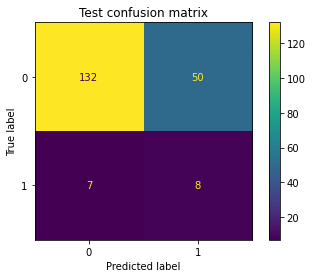

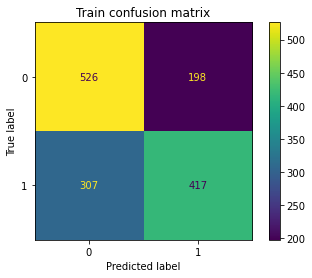

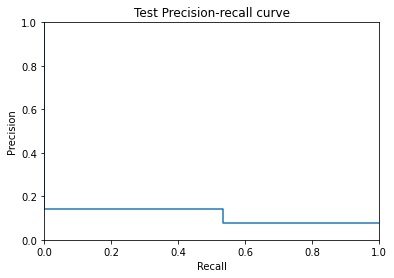

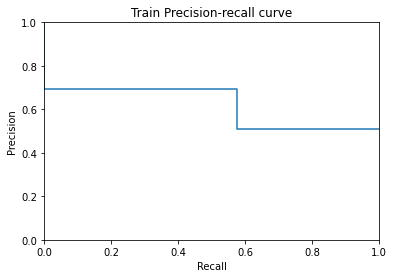

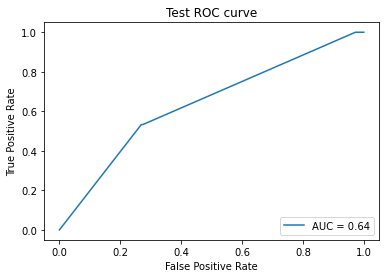

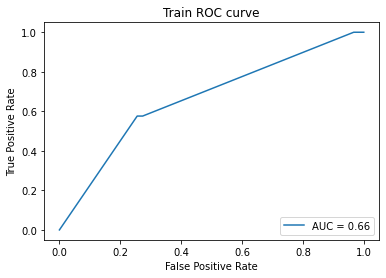

In [20]:
# crate the classifier
clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=10, max_depth=1, ccp_alpha=0.0)

# split the dataset
df_train_tmp, df_test_tmp = train_test_split(df, test_size=0.2)

# Extract feature and labels
X_train = df_train_tmp.drop(columns=["mi"])
y_train = df_train_tmp["mi"]
X_test = df_test_tmp.drop(columns=["mi"])
y_test = df_test_tmp["mi"]

# extend dataset
y_train_mi = y_train[y_train==1]
y_train_no_mi = y_train[y_train==0]
nb_mi_to_add = len(y_train_no_mi) - len(y_train_mi)

X_train_no_mi = X_train[y_train==0]
X_train_mi = X_train[y_train==1]

X_train_mi_to_add = X_train_mi.sample(nb_mi_to_add, replace=True)
y_train_mi_to_add = y_train[X_train_mi_to_add.index]

X_train = pd.concat([X_train_no_mi, X_train_mi, X_train_mi_to_add])
y_train = pd.concat([y_train_no_mi, y_train_mi, y_train_mi_to_add])

# normalise
X_test["age"] = (X_test["age"]-X_train["age"].mean())/X_train["age"].std()
X_test["bmi"] = (X_test["bmi"]-X_train["bmi"].mean())/X_train["bmi"].std()
X_test["eGFR_bln"] = (X_test["eGFR_bln"]-X_train["eGFR_bln"].mean())/X_train["eGFR_bln"].std()
X_train["age"] = (X_train["age"]-X_train["age"].mean())/X_train["age"].std()
X_train["bmi"] = (X_train["bmi"]-X_train["bmi"].mean())/X_train["bmi"].std()
X_train["eGFR_bln"] = (X_train["eGFR_bln"]-X_train["eGFR_bln"].mean())/X_train["eGFR_bln"].std()

# fit
clf.fit(X_train, y_train)

# predict
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
y_pred_proba_test = clf.predict_proba(X_test)[:, 1]
y_pred_proba_train= clf.predict_proba(X_train)[:, 1]

# Disp perf
print("Test acc {:.2f}%".format(100*np.mean(accuracy_score(y_test, y_pred_test)), 100*np.std(accuracy_score(y_test, y_pred_test))))
print("Train acc {:.2f}%\n".format(100*np.mean(accuracy_score(y_train, y_pred_train)), 100*np.std(accuracy_score(y_train, y_pred_train))))
print("Test F1 {:.2f}".format(np.mean(f1_score(y_test, y_pred_test)), np.std(f1_score(y_test, y_pred_test))))
print("Train F1 {:.2f}\n".format(np.mean(f1_score(y_train, y_pred_train)), np.std(f1_score(y_train, y_pred_train))))
print("Test recall {:.2f}".format(np.mean(recall_score(y_test, y_pred_test)), np.std(recall_score(y_test, y_pred_test))))
print("Train recall {:.2f}\n".format(np.mean(recall_score(y_train, y_pred_train)), np.std(recall_score(y_train, y_pred_train))))
print("Test precision {:.2f}".format(np.mean(precision_score(y_test, y_pred_test)), np.std(precision_score(y_test, y_pred_test))))
print("Train precision {:.2f}\n".format(np.mean(precision_score(y_train, y_pred_train)), np.std(precision_score(y_train, y_pred_train))))
print("Test specifictiy {:.2f}".format(np.mean(recall_score(y_test, y_pred_test, pos_label=0)), np.std(recall_score(y_test, y_pred_test, pos_label=0))))
print("Train specifictiy {:.2f}\n".format(np.mean(recall_score(y_train, y_pred_train, pos_label=0)), np.std(recall_score(y_train, y_pred_train, pos_label=0))))
#print("Test sensibility {:.2f} ∓ {:.2f}".format(np.mean(sens_l), np.std(sens_l)))
#print("Train sensibility {:.2f} ∓ {:.2f}\n".format(np.mean(sens_train_l), np.std(sens_train_l)))
print("Test ROC-AUC {:.2f}".format(np.mean(roc_auc_score(y_test, y_pred_proba_test))))
print("Train ROC-AUC {:.2f}\n".format(np.mean(roc_auc_score(y_train, y_pred_proba_train))))
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
print("Test AUC {:.2f}".format(auc(recall, precision)))
precision, recall, thresholds = precision_recall_curve(y_train, y_pred_proba_train)
print("Train AUC {:.2f}".format(auc(recall, precision)))

# plot perf
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Test confusion matrix")

cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Train confusion matrix")
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("Test Precision-recall curve")

precision, recall, thresholds = precision_recall_curve(y_train, y_pred_proba_train)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("Train Precision-recall curve");

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.title("Test ROC curve");

fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba_train)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.title("Train ROC curve");

----